In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline

/home/pataki/.local/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
def within_dillution(y_true, y_pred, dill=2):
    frac = np.array(y_true) / np.array(y_pred)
    return ((frac >= 1/dill) & (frac <= dill)).mean()

In [3]:
base = '/mnt/local/scratch/pataki/AMR_pred/final_processed/'

data = pd.read_csv(f'{base}merged_top50.csv').fillna('NA')
data = data[data.measurement_units == 'mg/L']
data.pop('measurement_units');
data.pop('sample_alias');

testDF = data[data.country == 'NA']
testDF.pop('country');
y = testDF.pop('measurement')

testDF.head()

,CP009072.1_167295,CP009072.1_167306,CP009072.1_1589734,qnrS1,blaCTX-M-55,CP009072.1_3517597,CP009072.1_3517591,CP009072.1_1734215,CP009072.1_3517573,CP009072.1_113480,...,CP009072.1_4776473,CP009072.1_1176932,CP009072.1_113516,CP009072.1_3517509,CP009072.1_3517722,CP009072.1_3166388,CP009072.1_3517100,CP009072.1_3934862,CP009072.1_2536847,CP009072.1_548079
430,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
431,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
432,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
433,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
434,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [4]:
with open(f'{base}rf_4.pkl', 'rb') as f:
    rf_4 = pickle.load(f)
    
with open(f'{base}lr_4.pkl', 'rb') as f:
    lr_4 = pickle.load(f)
    
rf4_pred = rf_4.predict(testDF[testDF.columns.values[:4]])
lr4_pred = lr_4.predict(testDF[testDF.columns.values[:4]])

In [5]:
with open(f'{base}rf_15.pkl', 'rb') as f:
    rf_15 = pickle.load(f)
    
with open(f'{base}lr_15.pkl', 'rb') as f:
    lr_15 = pickle.load(f)
    
rf15_pred = rf_15.predict(testDF[testDF.columns.values[:15]])
lr15_pred = lr_15.predict(testDF[testDF.columns.values[:15]])

In [6]:
def get_metrics(preds, truth, modelname, N_feat, threshold = 1):
    predDF = pd.DataFrame({'preds':preds, 'truth':truth})
    
    acc2 = within_dillution(y_true=truth, y_pred=preds, dill=2)
    acc4 = within_dillution(y_true=truth, y_pred=preds, dill=4)
    
    # r2 and Pearson is calculated on log scale
    r2   = r2_score(y_pred=np.log2(preds), y_true=np.log2(y))
    pear = pearsonr(x=np.log2(y), y=np.log2(preds))[0]
    
    # very major error and major error
    vme  = len(predDF[(predDF.preds<threshold) & (predDF.truth>threshold)])
    me   = len(predDF[(predDF.preds>threshold) & (predDF.truth<threshold)])
    
    auc  = roc_auc_score(y_true = (predDF.truth > threshold), y_score=predDF.preds)
    dif  = abs(np.log2(predDF.preds.values) - np.log2(predDF.truth.values)).mean()

    resDF = pd.DataFrame({'R2':[r2], 'R':[pear], 'ME':[me], 'VME':[vme], 
                          'model':[modelname], 'AUC':[auc], 'ACC-2':[acc2], 
                          'ACC-4':[acc4], 'MAFE':[dif], 'N_feat': [N_feat]})
    
    return resDF[['model', 'N_feat', 'R2', 'R', 'ME', 'VME', 
                  'AUC', 'ACC-2', 'ACC-4', 'MAFE']].round(3)

In [7]:
rf4_metrics  = get_metrics(truth=y, preds=2**rf4_pred, modelname='random forest', N_feat=4)
rf15_metrics = get_metrics(truth=y, preds=2**rf15_pred, modelname='random forest', N_feat=15)
lr4_metrics  = get_metrics(truth=y, preds=2**lr4_pred, modelname='linear regression', N_feat=4)
lr15_metrics = get_metrics(truth=y, preds=2**lr15_pred, modelname='linear regression', N_feat=15)

rf4_metrics.append(rf15_metrics).append(lr4_metrics).append(lr15_metrics)

,model,N_feat,R2,R,ME,VME,AUC,ACC-2,ACC-4,MAFE
0,random forest,4,0.932,0.966,0,0,1.000,0.658,0.944,0.883
0,random forest,15,0.902,0.951,4,0,0.996,0.680,0.914,0.915
0,linear regression,4,0.918,0.959,0,2,1.000,0.650,0.929,0.954
0,linear regression,15,0.917,0.958,0,0,1.000,0.677,0.917,0.988


# Plot the results with 4 features

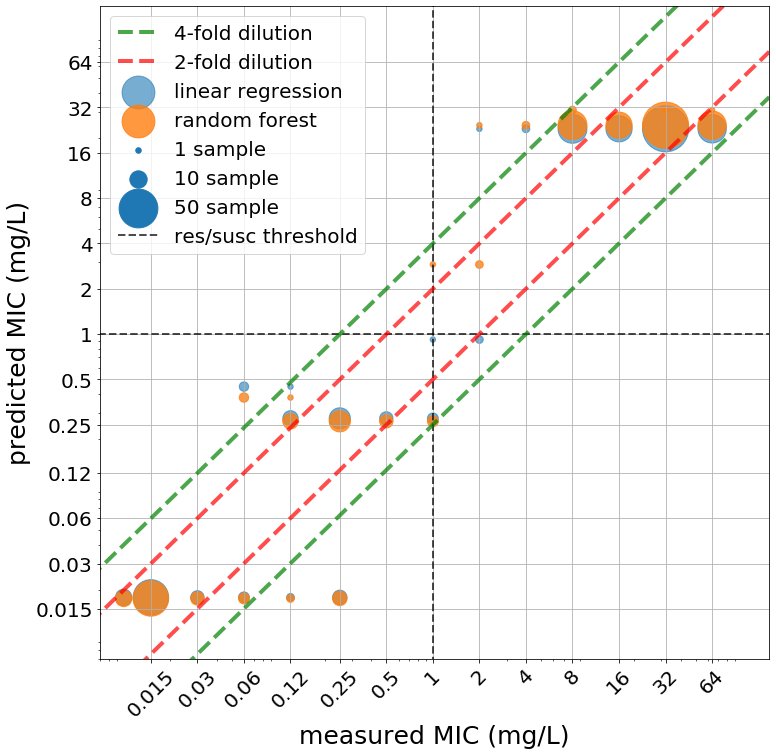

In [8]:
mult = 30
lrpredDF = pd.DataFrame({'pred': 2**(lr4_pred), 'truth' : y})
lrplotDF = lrpredDF.reset_index().groupby(['pred', 'truth']).count().reset_index()

rfpredDF = pd.DataFrame({'pred': 2**(rf4_pred), 'truth' : y})
rfplotDF = rfpredDF.reset_index().groupby(['pred', 'truth']).count().reset_index()

plt.rcParams['figure.figsize'] = (12, 12)
plt.scatter(lrplotDF.truth.tolist(), lrplotDF.pred.tolist(), 
            s=np.array(lrplotDF['index'].tolist())*mult, label='linear regression', alpha=0.6)
plt.scatter(rfplotDF.truth.tolist(), rfplotDF.pred.tolist(), 
            s=np.array(rfplotDF['index'].tolist())*mult, label='random forest', alpha=0.8)


plt.scatter(-1, -1, s=1*mult, label='1 sample', c='C0')
plt.scatter(-1, -1, s=10*mult, label='10 sample', c='C0')
plt.scatter(-1, -1, s=50*mult, label='50 sample', c='C0')



x = np.linspace(0, 150, 150)
plt.plot(x, 4*x, c='g', label='4-fold dilution', ls='--', lw=4, alpha=0.7)
plt.plot(x, 1/4*x, c='g', ls='--', lw=4, alpha=0.7)
plt.plot(x, 2*x, c='r', ls='--', lw=4, alpha=0.7)
plt.plot(x, 1/2*x, c='r', label='2-fold dilution', ls='--', lw=4, alpha=0.7)

plt.xlim(0.007, 150)
plt.ylim(0.007, 150)

plt.hlines(1, 0, 150, linestyles='--', lw=2, alpha=0.7)
plt.vlines(1, 0, 150, linestyles='--', lw=2, alpha=0.7, label='res/susc threshold')
plt.xlabel('measured MIC (mg/L)', fontsize=25)
plt.ylabel('predicted MIC (mg/L)', fontsize=25)
plt.legend(fontsize=20)
plt.xscale('log')
plt.yscale('log')

tck = [0.015, 0.03, 0.06, 0.12, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64]
plt.xticks(tck, [str(i) for i in tck], fontsize=20, rotation=45)
plt.yticks(tck, [str(i) for i in tck], fontsize=20)

plt.grid()
#plt.title('MIC (mg/L) prediction based on 4 markers', fontsize=25)
plt.savefig('../figs/cipro_MIC_scatter.pdf')
plt.show()

# Generate possible predictions table

In [9]:
print(np.round(lr_4.intercept_, 3), np.round(lr_4.coef_, 3))

-5.805 [4.648 3.947 1.738 4.211]


In [10]:
from itertools import compress, product

def combinations(items):
    return (list(compress(items,mask)) for mask in product(*[[0,1]]*len(items)))

In [11]:
possible_preds    = []
present_mutations = []

for mutations in list(combinations(range(4))):
    pred = 2**lr_4.intercept_
    for m in mutations:
        pred *= 2**lr_4.coef_[m]
    possible_preds.append(pred)
    present_mutations.append(mutations)

In [12]:
testDF.columns.values[:4]

array(['CP009072.1_167295', 'CP009072.1_167306', 'CP009072.1_1589734',
       'qnrS1'], dtype=object)

In [13]:
mutcode = {0:'gyrA#87', 1:'gyrA#83', 2:'parC#80', 3:'qnrS1'}

In [14]:
possible_predsDF = pd.DataFrame({'prediction (mg/L)': possible_preds,
                                 'gyrA#87':[0 in i for i in present_mutations], 
                                 'gyrA#83':[1 in i for i in present_mutations],
                                 'parC#80':[2 in i for i in present_mutations],
                                 'has_qnrS':[3 in i for i in present_mutations]}).round(3)
possible_predsDF = possible_predsDF.sort_values('prediction (mg/L)').set_index('prediction (mg/L)')
possible_predsDF = possible_predsDF.replace(True, 'Yes').replace(False, 'No')
possible_predsDF[['gyrA#87', 'gyrA#83', 'parC#80', 'qnrS1']]

KeyError: "['qnrS1'] not in index"

In [ ]:
with open('../tables/possible_predictions.txt', 'wt') as f:
    f.write(possible_predsDF[['gyrA#87', 'gyrA#83', 'parC#80', 'qnrS1']].to_latex())

# Table of the feature importances

In [ ]:
imp = pd.read_csv(f'{base}top50_important_features.csv')

with open('../tables/feature_importances.txt', 'wt') as f:
    f.write(imp.round(3).head(15).set_index('feat').to_latex())

# Table of metrics

In [ ]:
with open('../tables/metrics.txt', 'wt') as f:
    f.write(rf4_metrics.append(rf15_metrics).append(lr4_metrics).append(lr15_metrics).set_index('model').to_latex())